[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/DCT_basis.ipynb)

# 2D-DCT basis
2-dimensional Discrete Cosine Transform.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from scipy import fftpack

In [2]:
# Forward and backward DCT wrappers

def forward_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T
    # https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.fftpack.dct.html
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def inverse_2d_dct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    # https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.fftpack.idct.html
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

## $8\times 8$ DCT

* DCT exhibits a bad performance when applied to high resolution images, but locally it works pretty well. For this reason, most DCT-based image/video codecs divide the images in blocks (typically of 8x8 pixels) and apply the DCT to each block, independently. Let's see the basis functions (the synthesys filters's response to a Delta) of the 2D-DCT.

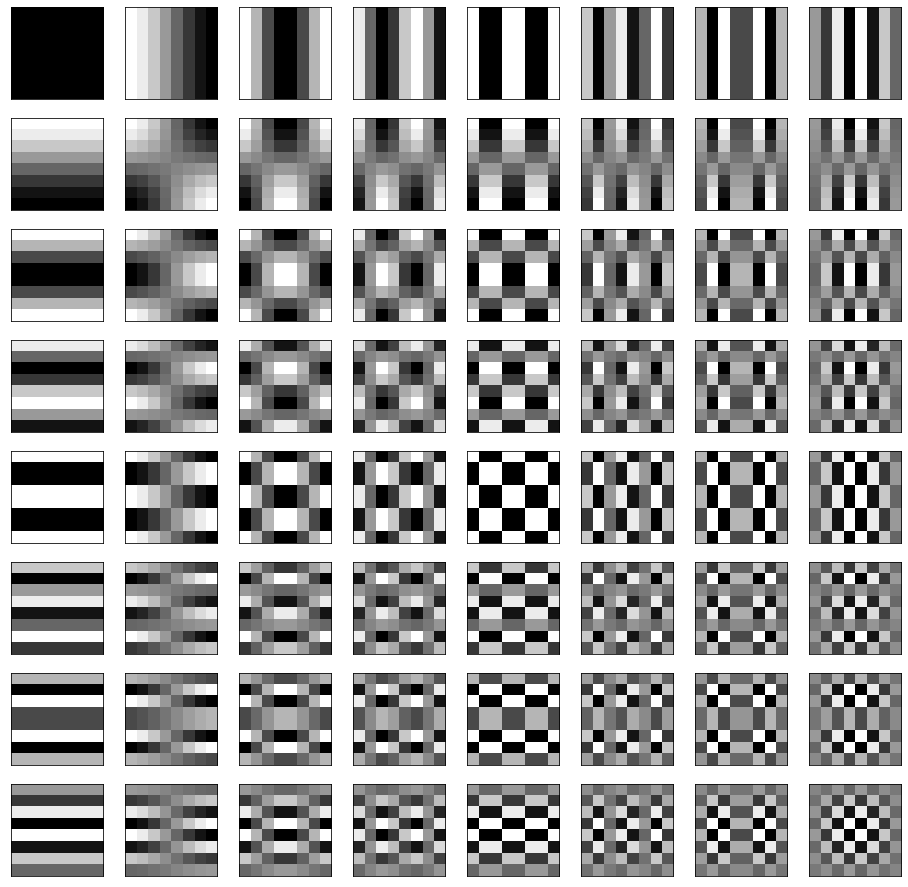

In [3]:
fig = plt.figure(figsize=(16, 16))
for i in range(8):
    for j in range(8):
        dct_copy = np.zeros((8, 8))

        dct_copy[i][j] = 1.0
        recons = inverse_2d_dct(dct_copy)
        
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255

        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

Now with more resolution:

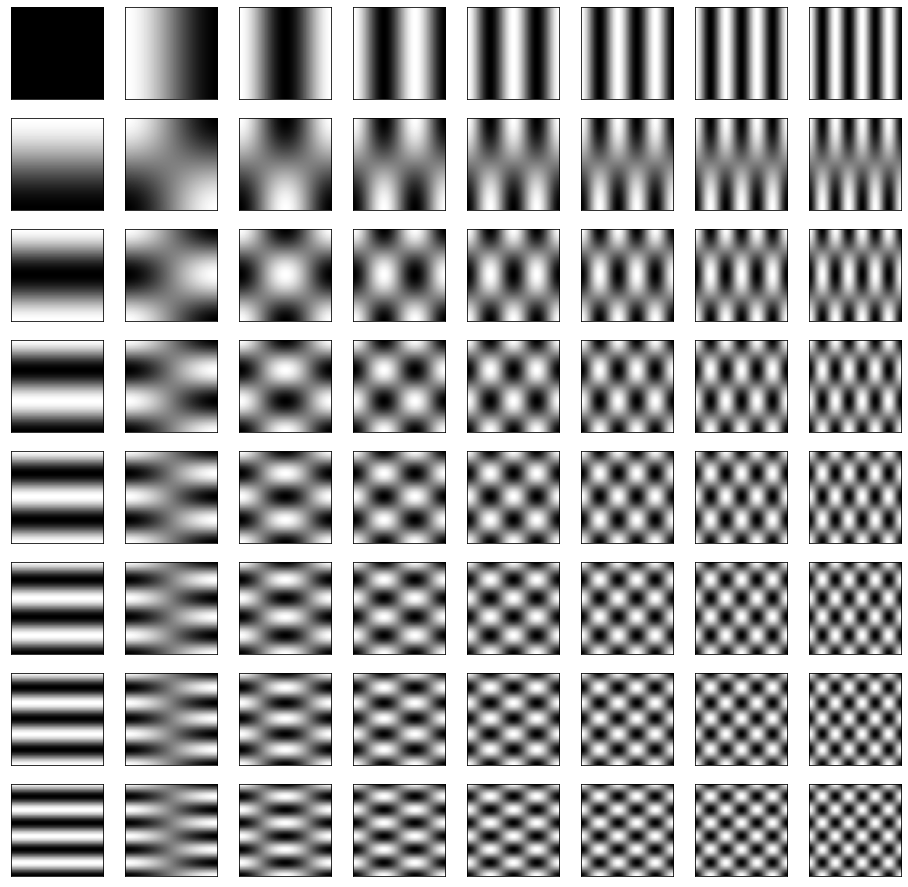

In [4]:
fig = plt.figure(figsize=(16, 16))
for i in range(8):
    for j in range(8):
        dct_copy = np.zeros((64, 64))

        dct_copy[i][j] = 1.0
        recons = inverse_2d_dct(dct_copy)
        
        max = recons.max()
        min = recons.min()
        if(max!=min):
            recons = (recons-min)/(max-min)*255

        plt.subplot(8, 8, 8*i+j+1)
        plt.imshow(recons, cmap=plt.cm.gray)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
plt.savefig("2D-DCT_basis.png")

## The rest of this notebook shows the progressive reconstruction of an image

In [ ]:
# Load lena

import urllib.request

%matplotlib inline
HTTP_response = urllib.request.urlopen('http://www.hpca.ual.es/~vruiz/images/lena.png')
arr = np.asarray(bytearray(HTTP_response.read()), dtype=np.uint8)
BRG = cv2.imdecode(arr,-1)
RGB = cv2.cvtColor(BRG, cv2.COLOR_BGR2RGB)
plt.imshow(RGB)

In [ ]:
# Color 2D-DCT is the 2D-DCT of each component
components = ('r','g','b')
dct = [None]*3
for i,com in enumerate(components):
    print("{} ".format(i), end='')
    dct[i] = forward_2d_dct(RGB[:,:,i])

In [ ]:
# View DCT coefs
view_dct = np.empty(RGB.shape)
for i,com in enumerate(components):
    view_dct[:,:,i] = dct[i][:,:]
#plt.imshow((view_dct - view_dct.min())/(view_dct.max() - view_dct.min())*255)
plt.imshow(view_dct + 128)

In [ ]:
# Reconstruct with biggest DCT coefs
N = 100 # Step size (in coeffs) for each reconstruction
for k in range(32): # Up to 32 reconstructions
    
    coeffs_indexes = np.empty((RGB.shape[0] * RGB.shape[1]), dtype='float, int, int')
    for i in range(RGB.shape[0]):
        for j in range(RGB.shape[1]):
            coeffs_indexes[i*RGB.shape[1]+j] = (np.abs(dct[0][i][j]), i, j)
    
    # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.sort.html
    sorted = np.sort(coeffs_indexes, axis = -1)[::-1]
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty.html
    x_coords = np.empty((k+1)*N, dtype='int')
    y_coords = np.empty((k+1)*N, dtype='int')
    for kk in range((k+1)*N):
        x_coords[kk] = sorted[kk][1]
        y_coords[kk] = sorted[kk][2]

    recons = np.empty(RGB.shape)
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html
    dct_copy = np.zeros(dct[0].shape)

    dct_copy[x_coords, y_coords] = dct[0][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.clip.html
    recons[:,:,0] = recons_[:,:].clip(0,255)
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty_like.html
    dct_copy = np.empty_like(dct[1])
    dct_copy[x_coords, y_coords] = dct[1][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    recons[:,:,1] = recons_[:,:].clip(0,255)

    dct_copy = np.empty_like(dct[2])
    dct_copy[x_coords, y_coords] = dct[2][x_coords, y_coords]
    recons_ = inverse_2d_dct(dct_copy)
    recons[:,:,2] = recons_[:,:].clip(0,255)
    
    plt.imshow(recons.astype('uint8'))
    plt.grid(False);
    plt.xticks([]);
    plt.yticks([]);
    print("{} coefficients".format((k+1)*N), end='')
    plt.show()
